## Correction factor = 0.8

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
mc = pd.read_csv('mc_sideband.csv', index_col='eid')
data = pd.read_csv('onpeak_data_sideband.csv', index_col='eid')
offpeak = pd.read_csv('offpeak_data_sideband.csv', index_col='eid')
offpeak_weights = pd.read_csv('offpeak_weights.csv')
Dstarstar_modes = pd.read_csv('brf_others.dat')
Dstarstar_modes = Dstarstar_modes['ModeString'].values.tolist()

mc = mc.loc[(mc['mode_label']!=998) & (mc['mode_label']!=1005)]
offpeak = pd.merge(offpeak, offpeak_weights, on='run')

In [4]:
# Global variables for plotting
weight_col_names = ['weight', 'lumi_weight', 'brf_correction_weight', 'cln_weight', 'llswb1_weight', 'llswb2_weight']

# Change these if necessary:
run = 0 # = 0 for all runs
nbins_default = 45
normed_flag = False
plot_log_true = False
save_figures_flag = False

# Shouldn't have to change these:
golden = (1 + 5 ** 0.5) / 2
figwidth = 8
fsize = 12
hastie_colors = [ '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#CC79A7', '#D55E00', '#0072B2' ]

In [5]:
def get_dstarstar_correction(row, factor):
    b1_weight = factor if row.b1_brf_mode in Dstarstar_modes else 1.
    b2_weight = factor if row.b2_brf_mode in Dstarstar_modes else 1.
    return b1_weight * b2_weight

In [6]:
mc = mc.loc[mc["logit_logre_signal_score"].notnull() &
            mc["logit_gbdt300_signal_score"].notnull() &
            mc["logit_logre_dstartau_score"].notnull() &
            mc["logit_gbdt300_dstartau_score"].notnull()]
offpeak = offpeak.loc[offpeak["logit_logre_signal_score"].notnull() &
                      offpeak["logit_gbdt300_signal_score"].notnull() &
                      offpeak["logit_logre_dstartau_score"].notnull() &
                      offpeak["logit_gbdt300_dstartau_score"].notnull()]
mc1_clean = mc.copy()
mc1_clean.weight = mc1_clean.apply(lambda row: row.lumi_weight * row.brf_correction_weight *
                                               row.cln_weight * row.llswb1_weight * 25 *
                                               get_dstarstar_correction(row, 0.8), axis = 1)

In [7]:
def create_hist(var_name, data_range=None, nbins=nbins_default, 
                normed_flag=False, run=run, legend_loc=1, plot_yaxis=False,
                save_figures=save_figures_flag):
    if run != 0:
        mc1 = mc1_clean.loc[mc1_clean['run']==run].loc[:,[var_name,'grouped_dss_evttype'] + weight_col_names]
        data_var = data.loc[data['run']==run].loc[:,var_name]
        offpeak_var = offpeak.loc[offpeak['run']==run].loc[:,[var_name,'weight']]
        if data_range: # Specific run with data cuts
            mc1 = mc1.loc[(mc1[var_name] >= data_range[0]) & 
                          (mc1[var_name] <= data_range[1])]
            offpeak_var = offpeak_var.loc[(offpeak_var[var_name] >= data_range[0]) & 
                                          (offpeak_var[var_name] <= data_range[1])]
            data_var = [x for x in data_var if x >= data_range[0] and x <= data_range[1]]
    else:
        mc1 = mc1_clean.loc[:,[var_name,'grouped_dss_evttype'] + weight_col_names]
        data_var = data.loc[:,var_name]
        offpeak_var = offpeak.loc[:,[var_name, 'weight']]
        if data_range: # All runs with data cuts
            mc1 = mc1.loc[(mc1[var_name] >= data_range[0]) & 
                          (mc1[var_name] <= data_range[1])]
            offpeak_var = offpeak_var.loc[(offpeak_var[var_name] >= data_range[0]) & 
                                          (offpeak_var[var_name] <= data_range[1])]
            data_var = [x for x in data_var if x >= data_range[0] and x <= data_range[1]]
    
    # Define plot and figure
    fig = plt.figure(figsize=(figwidth*golden,figwidth))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax = fig.add_subplot(gs[0])
    
    # Plot data as points with error bars; save binning information
    data_counts, bin_edges = np.histogram(data_var, nbins, normed=normed_flag)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    data_err = [x**0.5 for x in data_counts]
    ax.errorbar(bin_centers, data_counts, yerr=data_err, 
                fmt='.', mfc='black', mec='black', ecolor='black',# ms=4,
                label='Data')
    
    # Get components
    mc_counts,_,_=ax.hist(
        [mc1.loc[mc1['grouped_dss_evttype']==1].loc[:,var_name],
         mc1.loc[mc1['grouped_dss_evttype']==2].loc[:,var_name],
         mc1.loc[mc1['grouped_dss_evttype']==3].loc[:,var_name],
         mc1.loc[mc1['grouped_dss_evttype']==4].loc[:,var_name],
         offpeak_var.loc[:,var_name]],
        bins = bin_edges,
        weights = [mc1.loc[mc1['grouped_dss_evttype']==1].loc[:,'weight'],
                   mc1.loc[mc1['grouped_dss_evttype']==2].loc[:,'weight'],
                   mc1.loc[mc1['grouped_dss_evttype']==3].loc[:,'weight'],
                   mc1.loc[mc1['grouped_dss_evttype']==4].loc[:,'weight'],
                   offpeak_var.loc[:,'weight']],
        #histtype = 'step',
        color = hastie_colors[:5],
        edgecolor = 'white',
        stacked = True,
        rwidth = 1.,
        label = [r'$D\tau_h$', r'$D^*\tau_h$', r'$D^{**}SL$', r'SLHad', r'Offpeak']
    )

    # Make plot look nice
    ax.legend(prop={'size':fsize}, loc=legend_loc)
    ax.set_xlabel(var_name, fontsize=fsize)
    ax.set_ylabel('Counts', fontsize=fsize)
    ax.tick_params(length=8, width=1, labelsize=fsize)
    if plot_yaxis:
        ax.set_yscale('log')
    #ax.set_xlim(data_range)
    
    # Add subplot for MC-data difference
    ax2 = fig.add_subplot(gs[1])
    diff_counts = [(x-y)/float(x) for x,y in zip(data_counts, mc_counts[4])]
    diff_err = [np.sqrt(y*(x+y)/x**3) for x,y in zip(data_counts, mc_counts[4])]
    ax2.errorbar(bin_centers, diff_counts, color='black',
                 yerr=diff_err, fmt='.')
    
    # Make it look nice
    ax2.set_xlabel(var_name, fontsize=fsize)
    ax2.set_ylabel('Data - MC / Data', fontsize=fsize)
    ax2.tick_params(length=8, width=1, labelsize=fsize-1)
    ax2.axhline(0, color='black')
    ax2.set_xlim(ax.get_xlim())
    ymin, ymax = ax2.get_ylim()
    ymin, ymax = -1.*max([abs(ymin), abs(ymax)]), max([abs(ymin), abs(ymax)])
    #ax2.set_ylim([ymin, ymax])
    ax2.set_ylim([-0.5, 0.5])
    
    if save_figures_flag:
        fig.savefig('{0}.pdf'.format(var_name), bbox_inches='tight')
    
    return fig

_ = create_hist('signal_score', data_range=[0,0.1])

_ = create_hist('dstartau_score', data_range=[0.2,0.7])

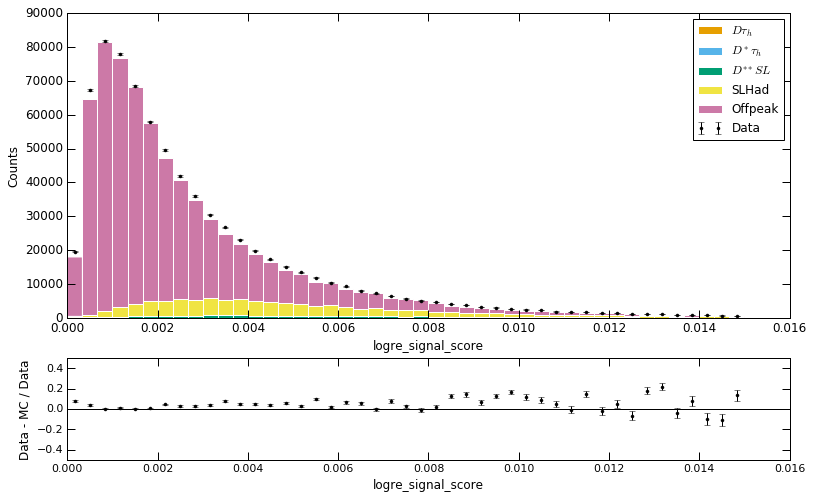

In [8]:
_=create_hist('logre_signal_score', data_range=[0,0.015], plot_yaxis=plot_log_true)

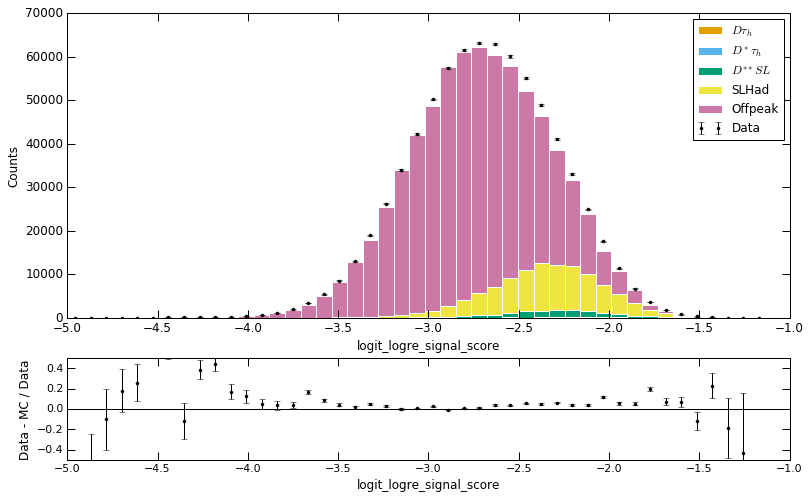

In [9]:
_=create_hist('logit_logre_signal_score', data_range=[-5.,0.], plot_yaxis=plot_log_true)

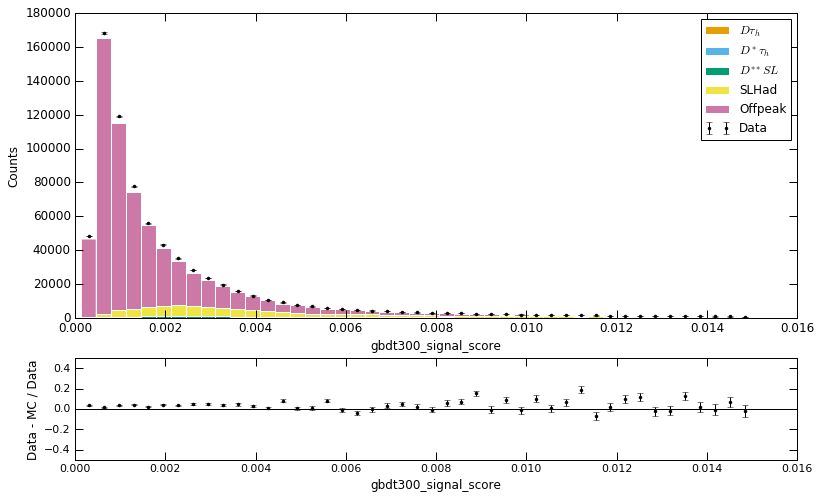

In [10]:
_=create_hist('gbdt300_signal_score', data_range=[0,0.015], plot_yaxis=plot_log_true)

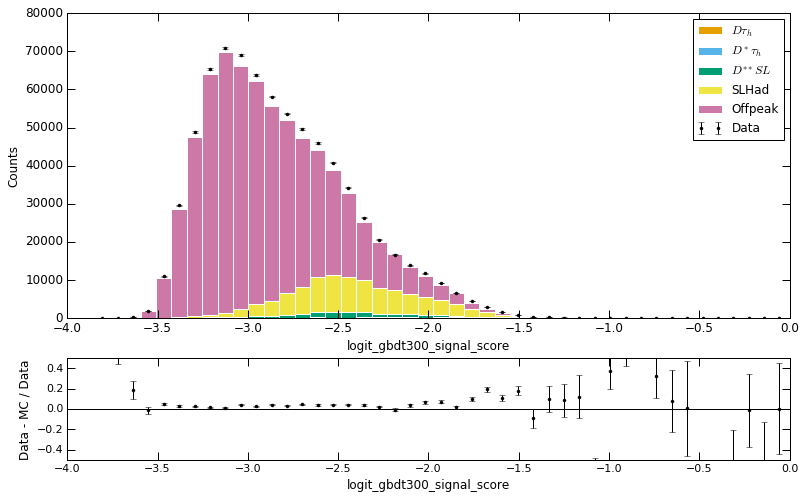

In [11]:
_=create_hist('logit_gbdt300_signal_score', data_range=[-5.,0], plot_yaxis=plot_log_true)

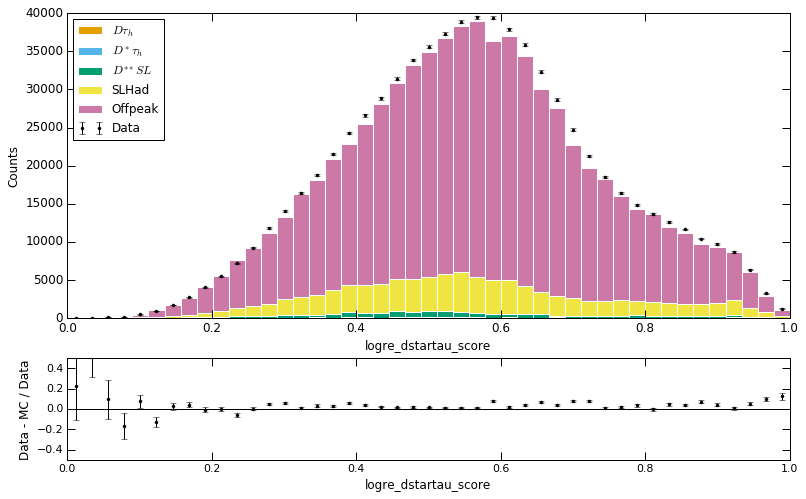

In [12]:
_=create_hist('logre_dstartau_score', legend_loc=2, plot_yaxis=plot_log_true)

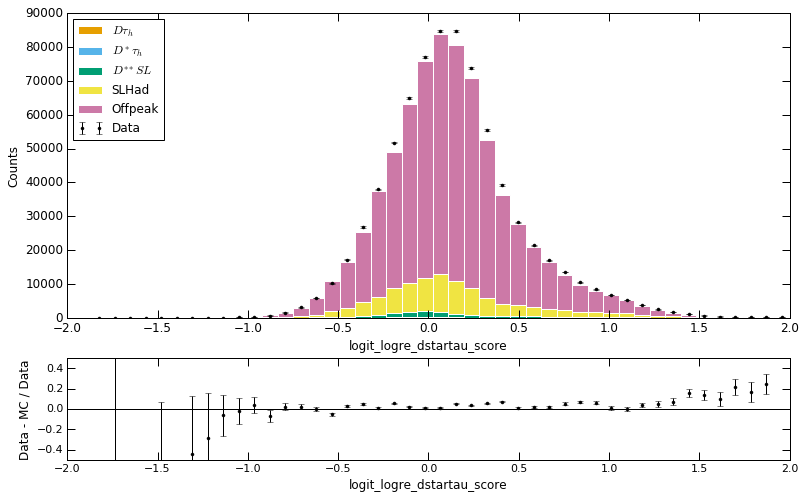

In [13]:
_=create_hist('logit_logre_dstartau_score', data_range=[-2, 2], legend_loc=2, plot_yaxis=plot_log_true)

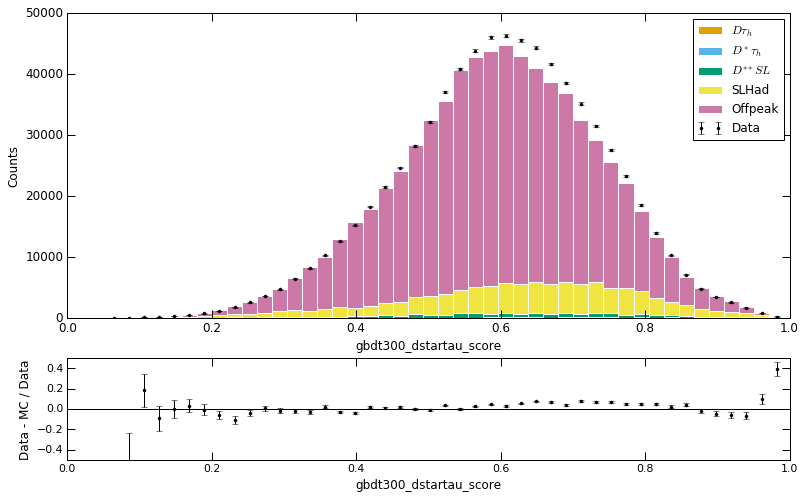

In [14]:
_=create_hist('gbdt300_dstartau_score', plot_yaxis=plot_log_true)

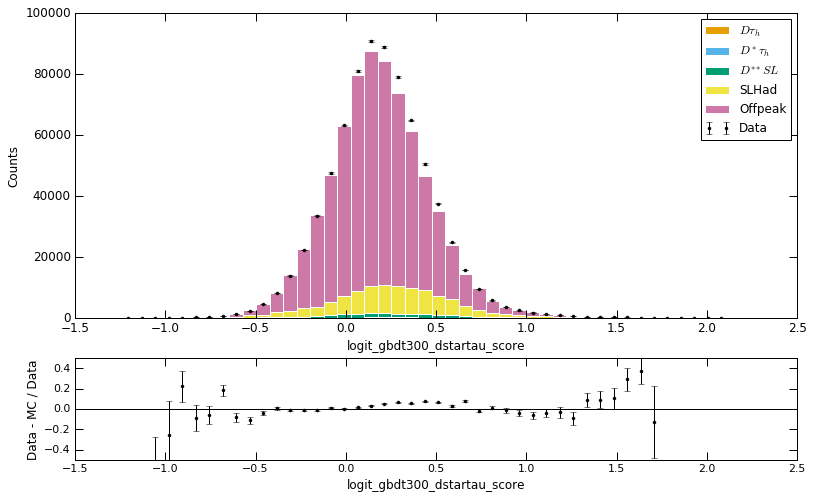

In [15]:
_=create_hist('logit_gbdt300_dstartau_score', plot_yaxis=plot_log_true)

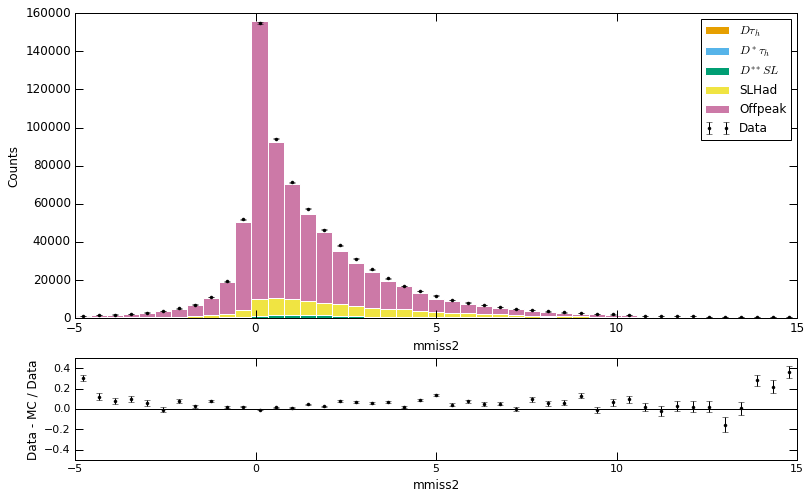

In [16]:
_=create_hist('mmiss2', data_range=[-5,15], plot_yaxis=plot_log_true)

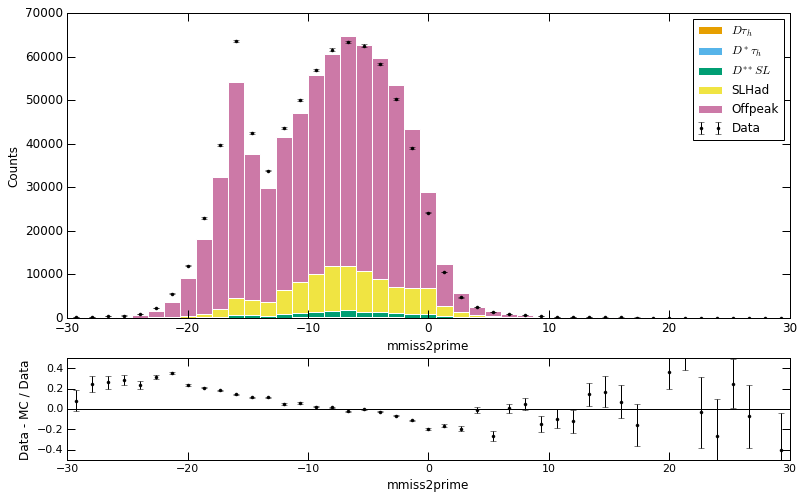

In [17]:
_=create_hist('mmiss2prime', data_range=[-30,30], plot_yaxis=plot_log_true)

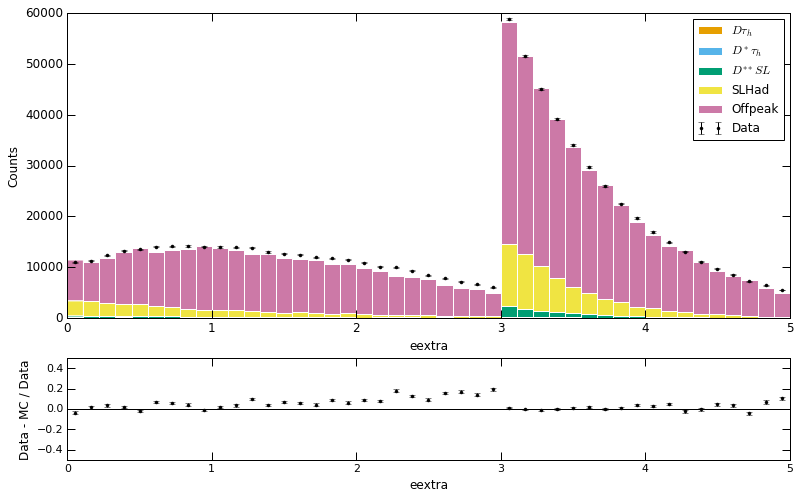

In [18]:
_=create_hist('eextra', data_range=[0,5], plot_yaxis=plot_log_true)

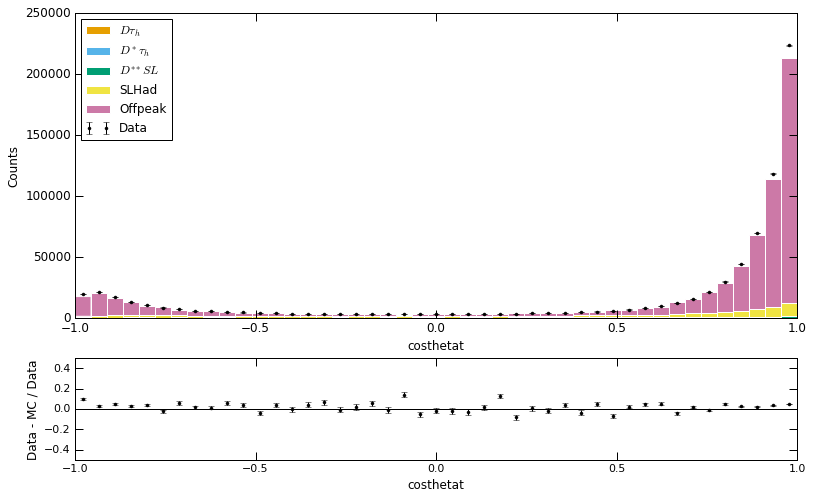

In [19]:
_=create_hist('costhetat', plot_yaxis=plot_log_true, legend_loc=2)

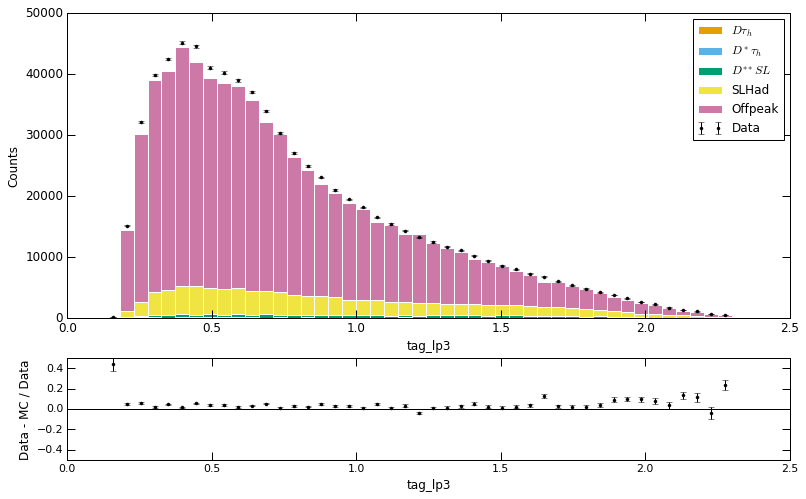

In [20]:
_=create_hist('tag_lp3', data_range=[0,2.3], plot_yaxis=plot_log_true)

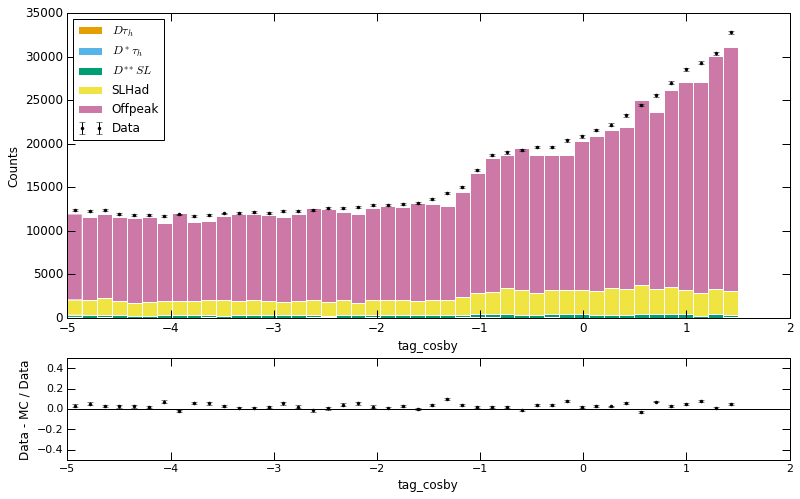

In [21]:
_=create_hist('tag_cosby', plot_yaxis=plot_log_true, legend_loc=2)

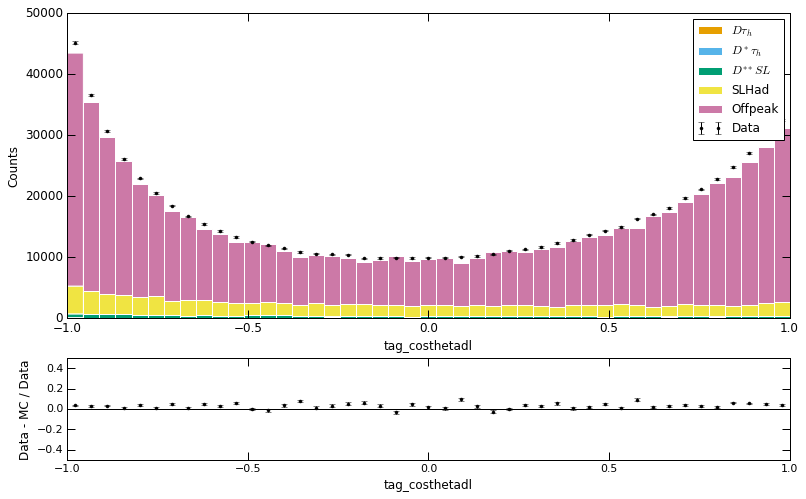

In [22]:
_=create_hist('tag_costhetadl', plot_yaxis=plot_log_true)

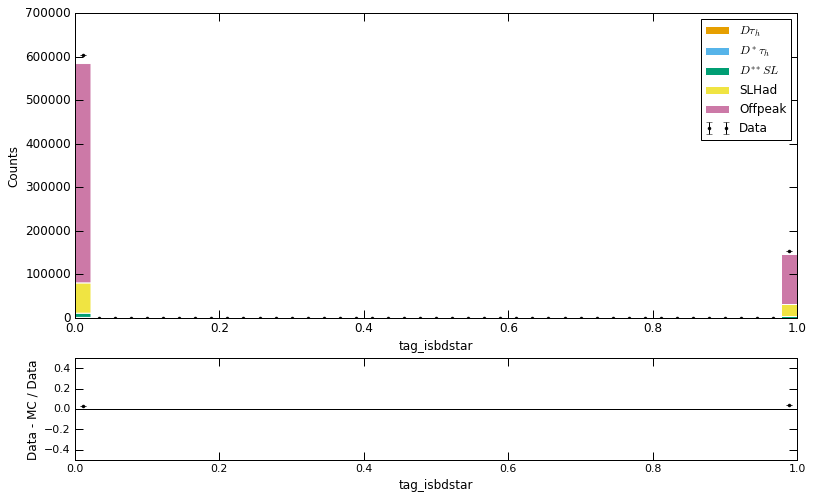

In [23]:
_=create_hist('tag_isbdstar', plot_yaxis=plot_log_true)

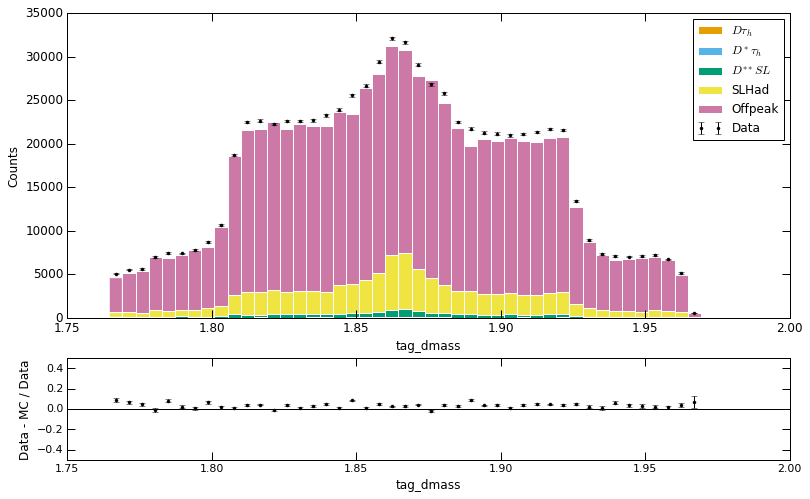

In [24]:
_=create_hist('tag_dmass', plot_yaxis=plot_log_true)

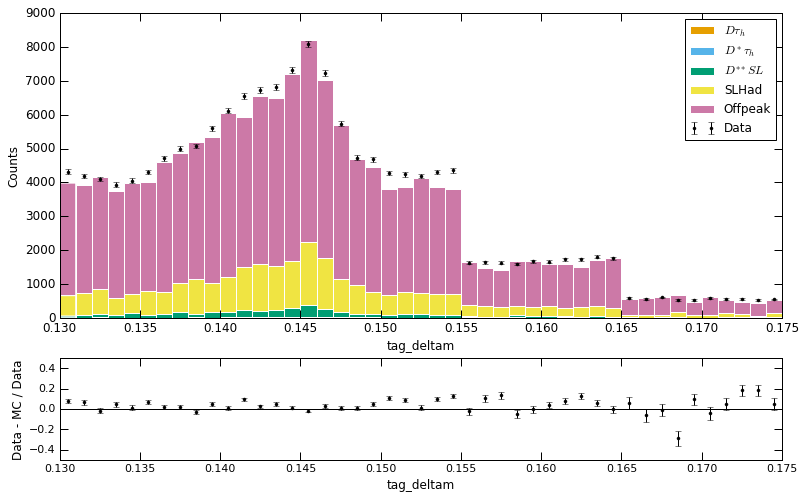

In [25]:
_=create_hist('tag_deltam', data_range=[0,2], plot_yaxis=plot_log_true)

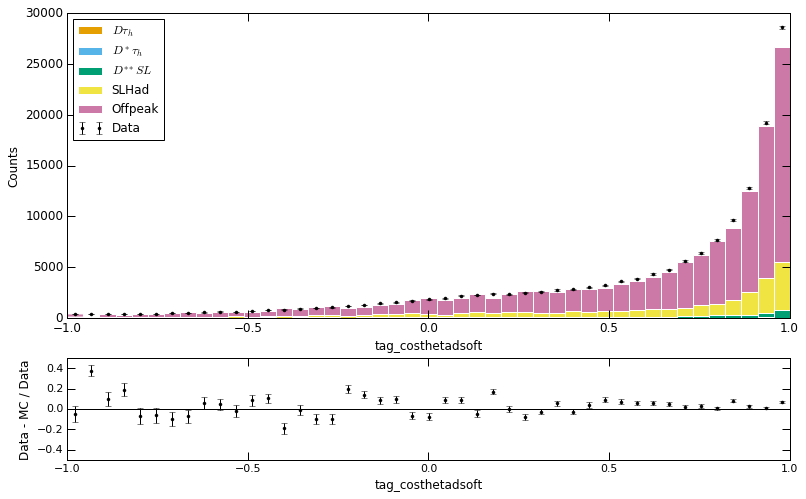

In [26]:
_=create_hist('tag_costhetadsoft', data_range=[-1.1, 1.1], plot_yaxis=plot_log_true, legend_loc=2)

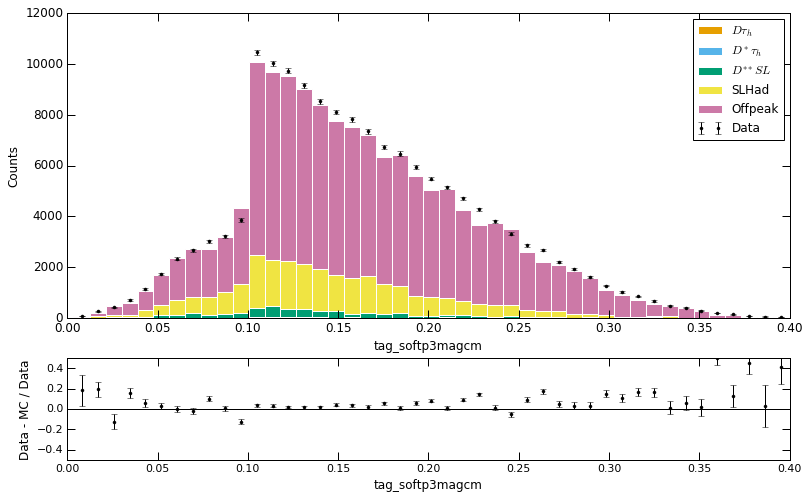

In [27]:
_=create_hist('tag_softp3magcm', data_range=[-0.1, 1], plot_yaxis=plot_log_true)

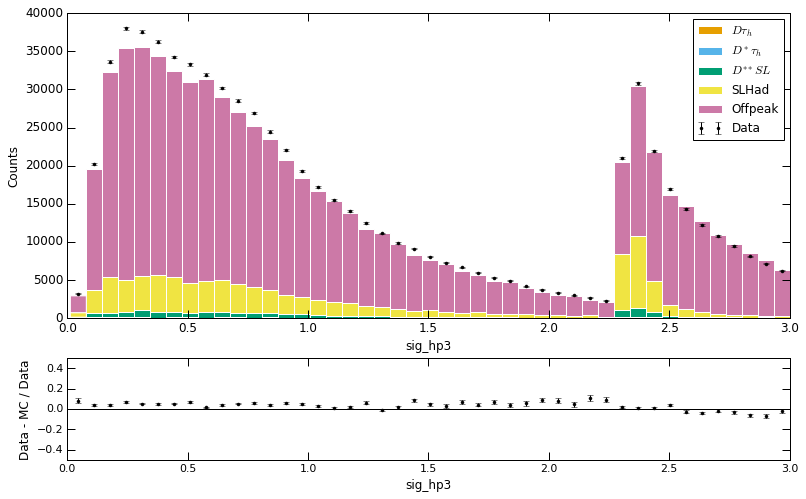

In [28]:
_=create_hist('sig_hp3', data_range=[0,3], plot_yaxis=plot_log_true)

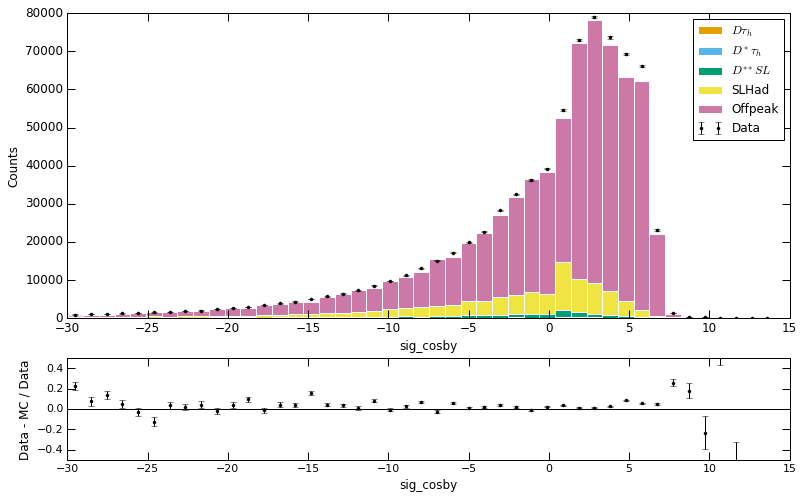

In [29]:
_=create_hist('sig_cosby', data_range=[-30,50], plot_yaxis=plot_log_true)

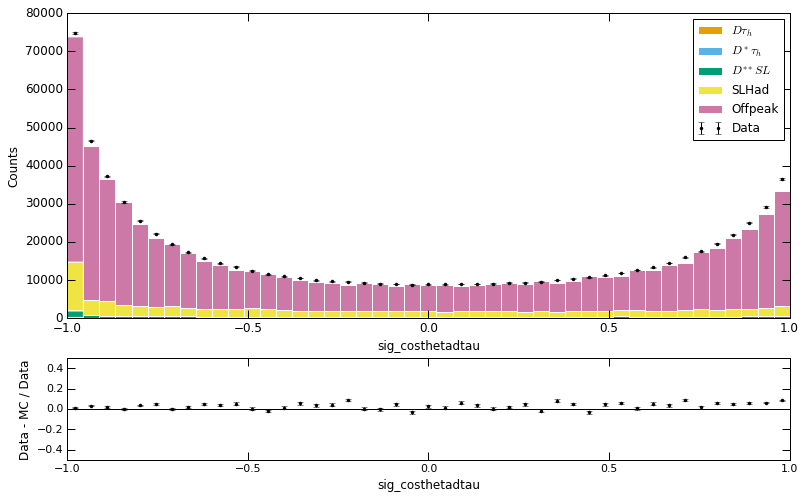

In [30]:
_=create_hist('sig_costhetadtau', plot_yaxis=plot_log_true)

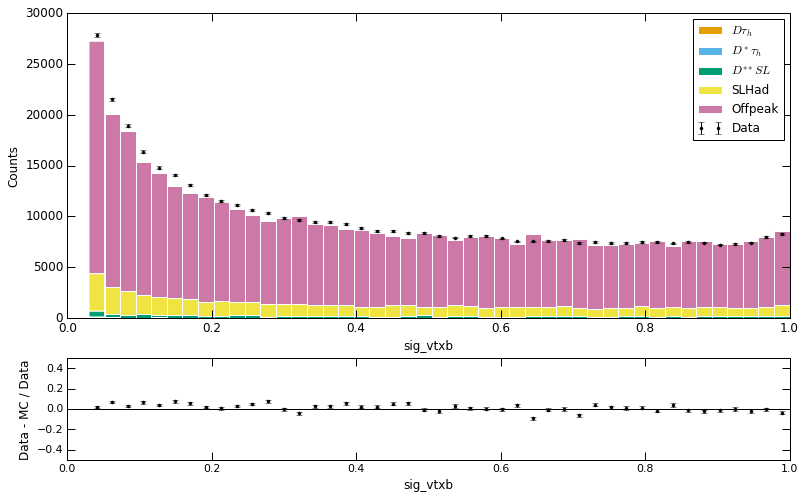

In [31]:
_=create_hist('sig_vtxb', data_range=[0.03,1], plot_yaxis=plot_log_true)

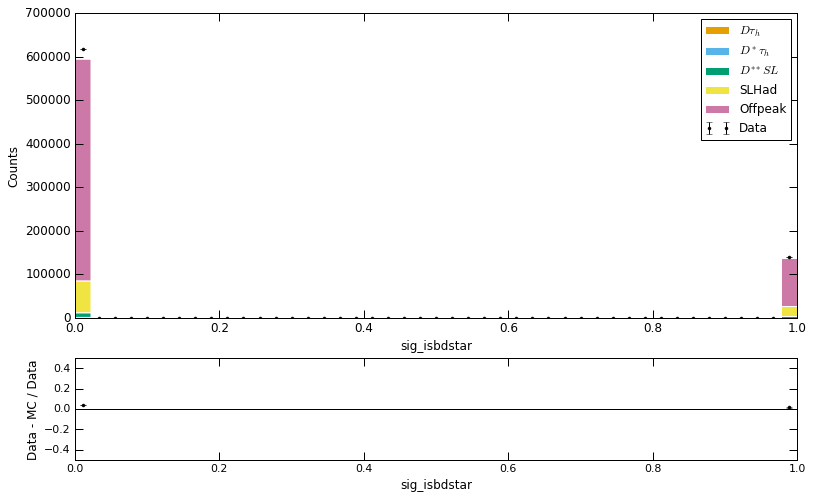

In [32]:
_=create_hist('sig_isbdstar', plot_yaxis=plot_log_true)

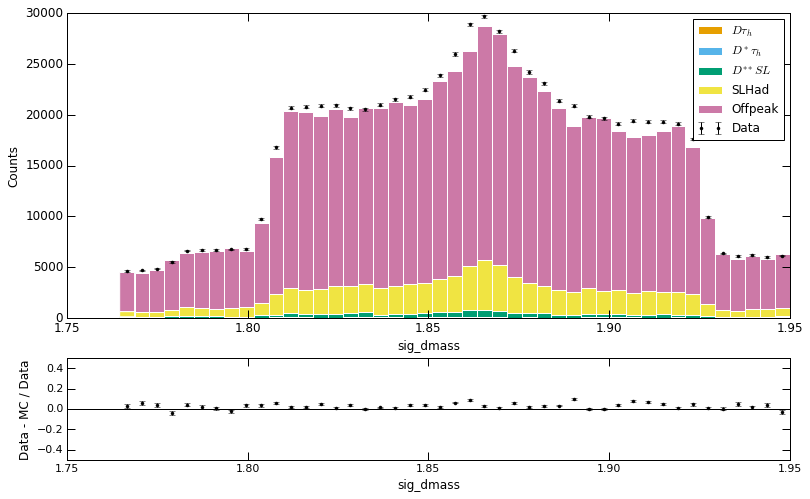

In [33]:
_=create_hist('sig_dmass', data_range=[1.5,1.95], plot_yaxis=plot_log_true)

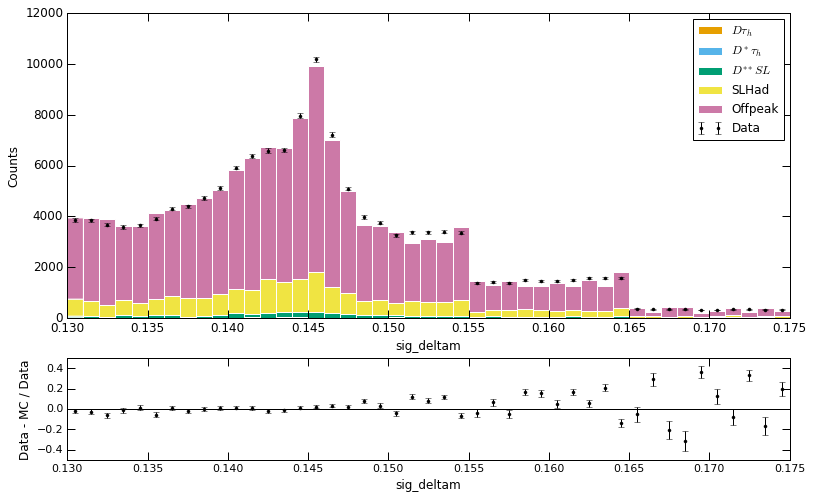

In [34]:
_=create_hist('sig_deltam', data_range=[0, 1], plot_yaxis=plot_log_true)

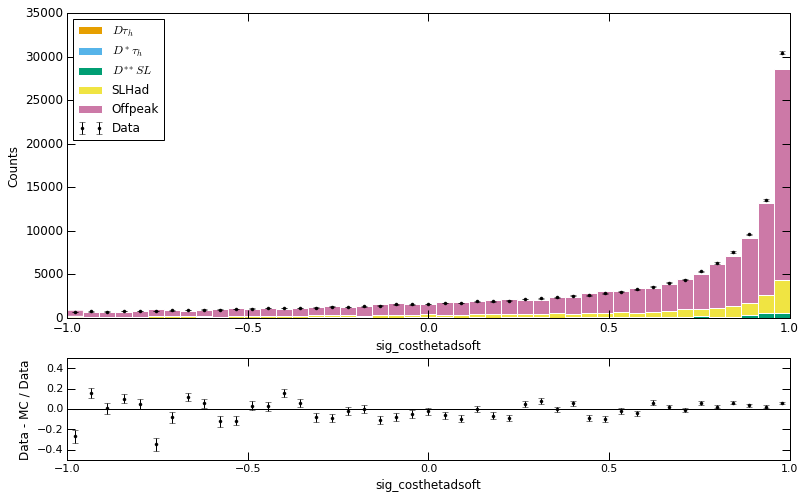

In [35]:
_=create_hist('sig_costhetadsoft', data_range=[-1.1, 1], plot_yaxis=plot_log_true, legend_loc=2)

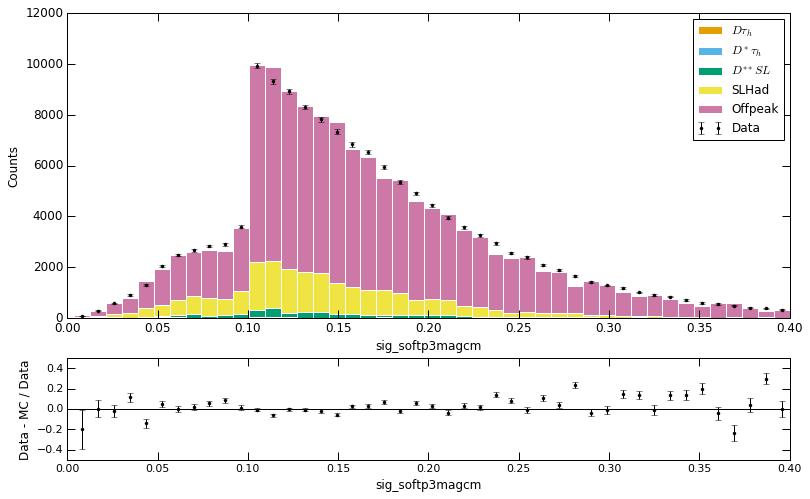

In [36]:
_=create_hist('sig_softp3magcm', data_range=[-0.5,1], plot_yaxis=plot_log_true)

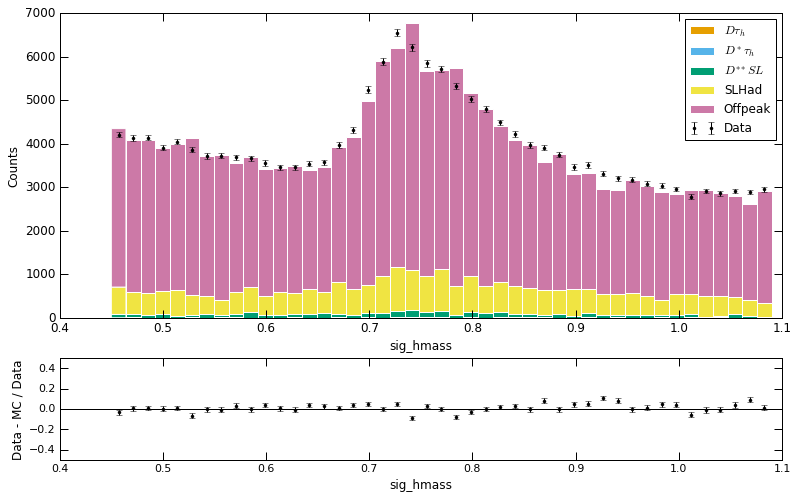

In [37]:
_=create_hist('sig_hmass', data_range=[0,2], plot_yaxis=plot_log_true)

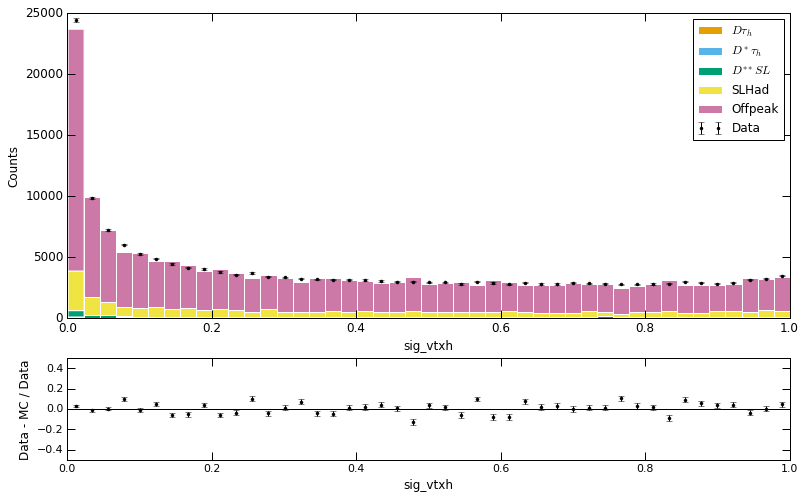

In [38]:
_=create_hist('sig_vtxh', data_range=[-0.5,2], plot_yaxis=plot_log_true)

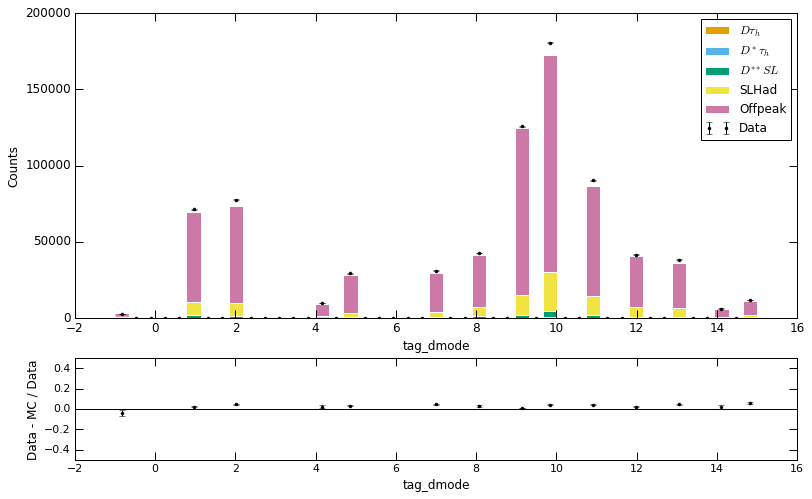

In [39]:
_=create_hist('tag_dmode', plot_yaxis=plot_log_true)

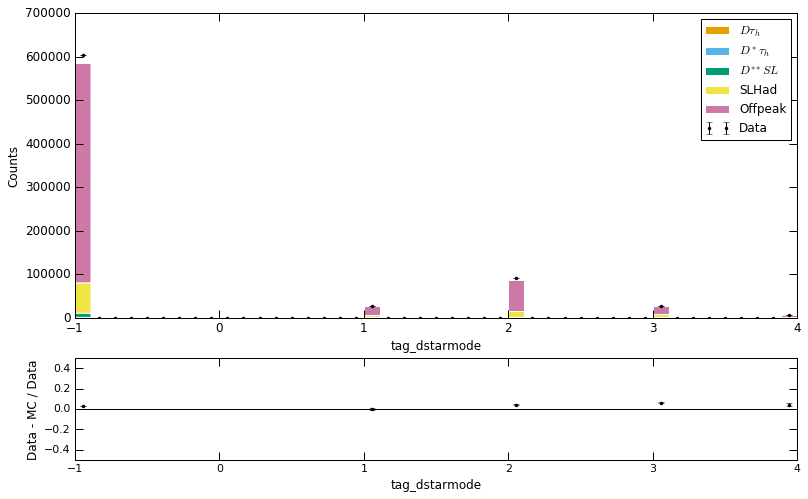

In [40]:
_=create_hist('tag_dstarmode', plot_yaxis=plot_log_true)

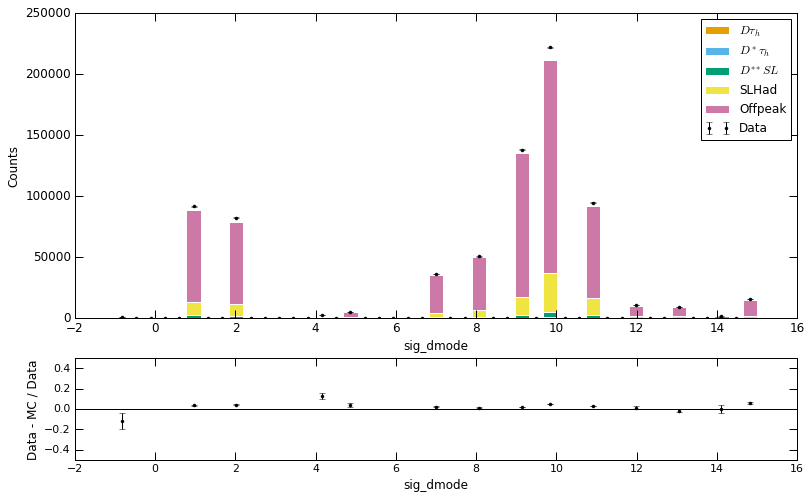

In [41]:
_=create_hist('sig_dmode', plot_yaxis=plot_log_true)

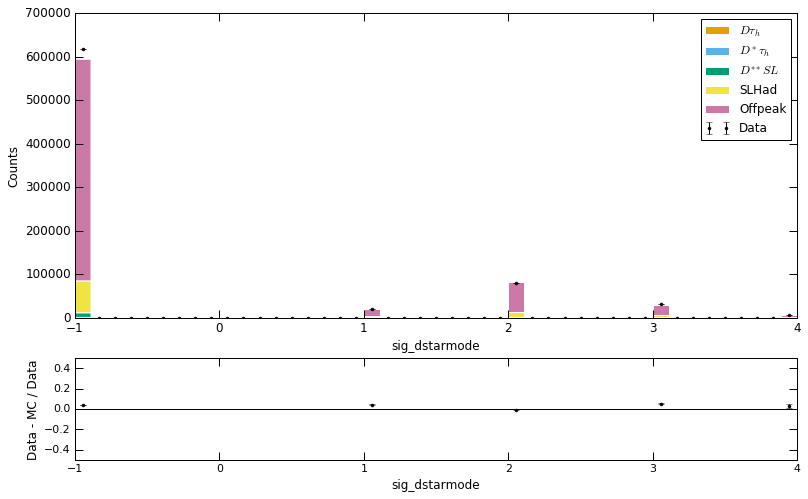

In [42]:
_=create_hist('sig_dstarmode', plot_yaxis=plot_log_true)

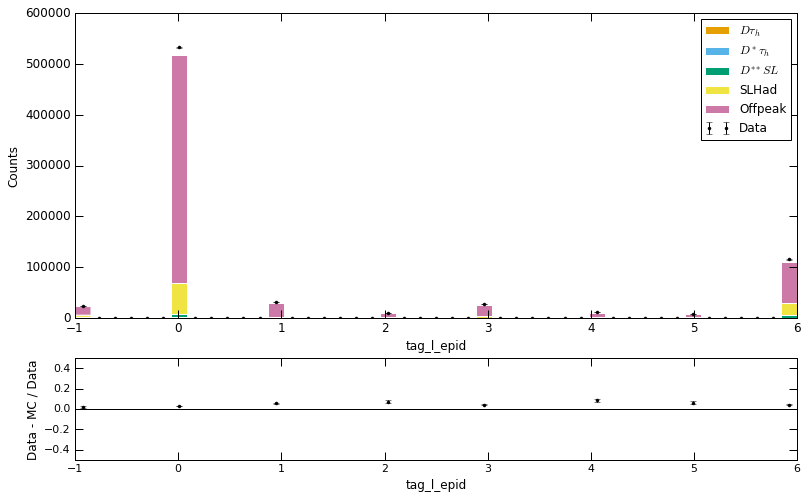

In [43]:
_=create_hist('tag_l_epid', plot_yaxis=plot_log_true)

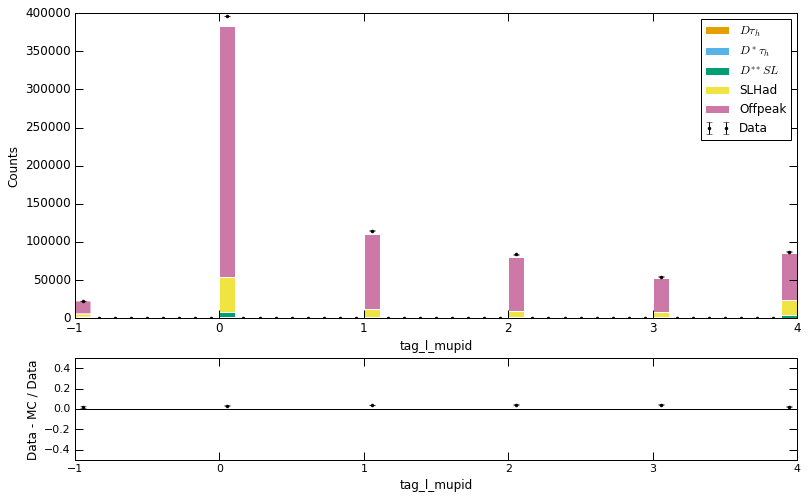

In [44]:
_=create_hist('tag_l_mupid', plot_yaxis=plot_log_true)

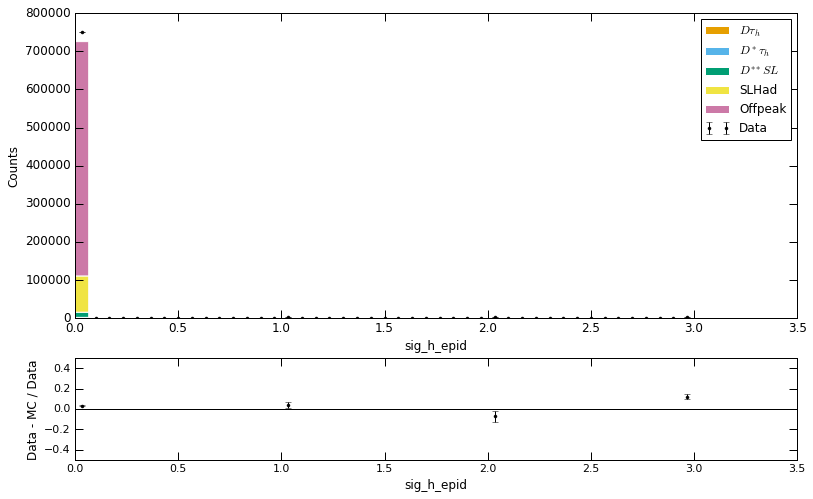

In [45]:
_=create_hist('sig_h_epid', plot_yaxis=plot_log_true)

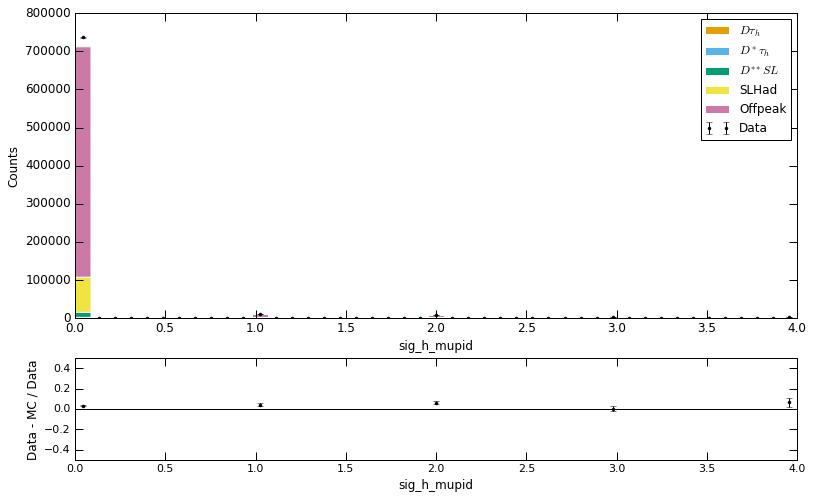

In [46]:
_=create_hist('sig_h_mupid', plot_yaxis=plot_log_true)

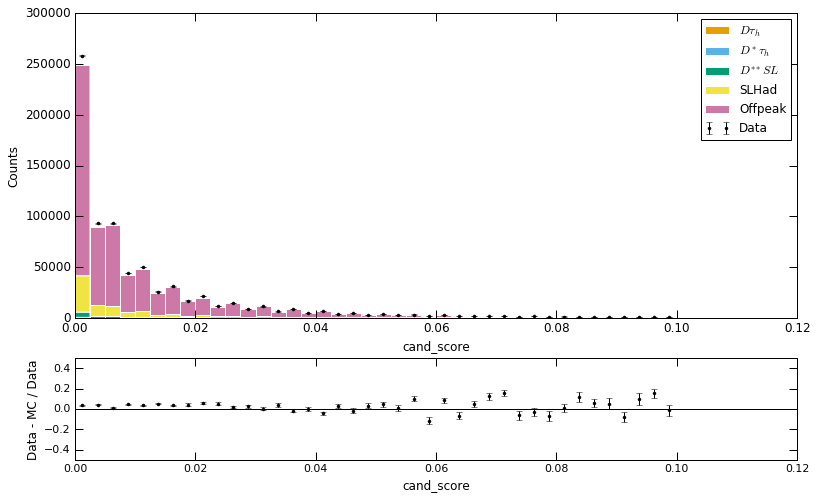

In [47]:
_=create_hist('cand_score', data_range=[0,0.1], nbins=40, plot_yaxis=plot_log_true)

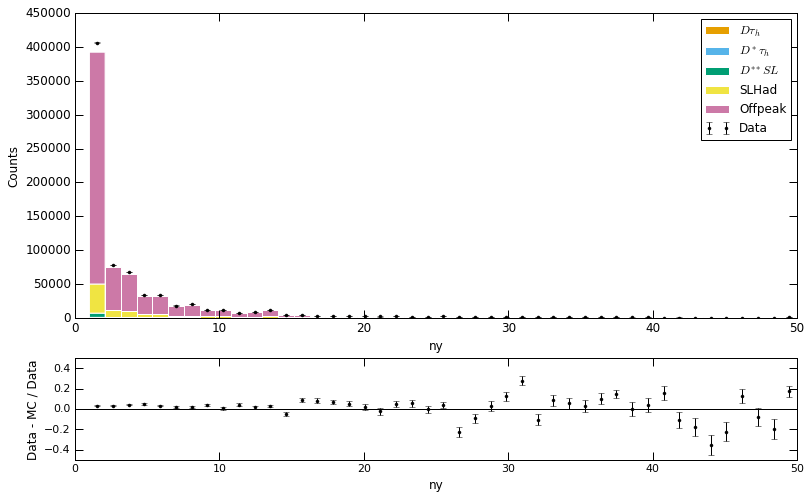

In [48]:
_=create_hist('ny', data_range=[0,50], plot_yaxis=plot_log_true)

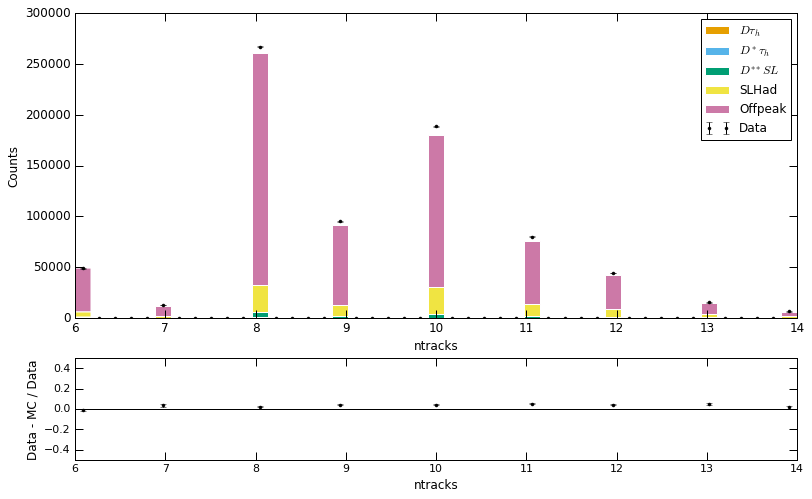

In [49]:
_=create_hist('ntracks', plot_yaxis=plot_log_true)

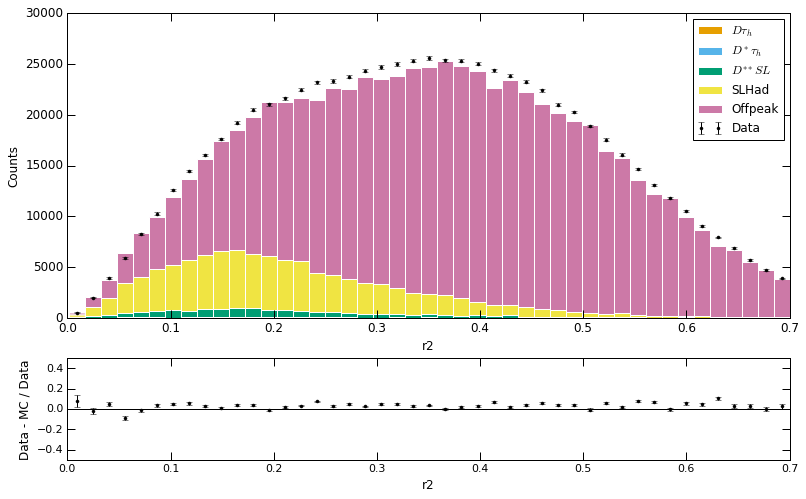

In [50]:
_=create_hist('r2', data_range=[0,0.7], plot_yaxis=plot_log_true)

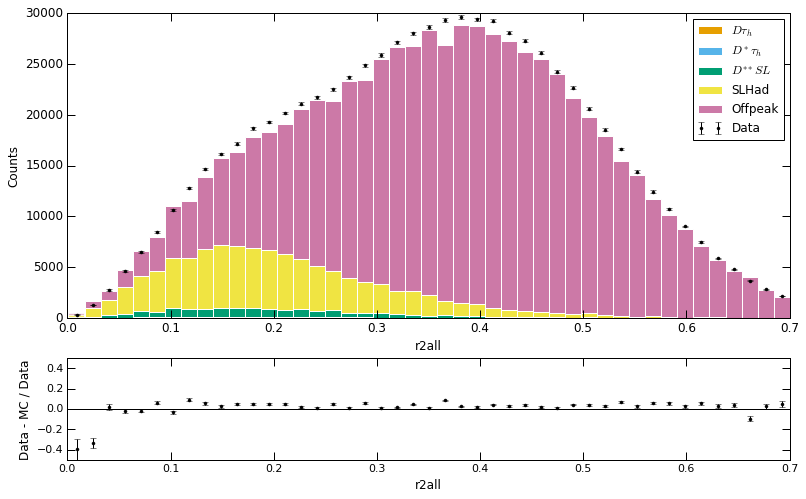

In [51]:
_=create_hist('r2all', data_range=[0,0.7], plot_yaxis=plot_log_true)